In [25]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")

from agents import make_pgg_agents
from pgg_env import PGGParallelEnv
from loop_pgg import run_simulation

from analysis_PGG import coop_timecourse_mean_sd, cc_mcc, alpha_fit_polyfit

In [26]:
SEED = 123
rng = np.random.default_rng(SEED)

# PGG setup
n_agents = 4
ep_length = 100
n_episodes = 25000
multiplication = 1.6
X = 0.4

# BM params
p_init = 0.5
A0 = 0.9
beta = 0.5
p_init_mode = "random"
sigma = 0.2

# Aspiration dynamique
eta_list = [0.0, 0.01, 0.05, 0.1]


In [27]:
def run_experiment_pgg(eta, seed = 0):
    env = PGGParallelEnv(
        n_agents=n_agents,
        ep_leng=ep_length,
        multiplication=multiplication,
        coop_threshold=X
    )

    agents = make_pgg_agents(
        n_agents=n_agents,
        A=A0,
        beta=beta,
        coop_threshold=X,
        p_init=p_init,
        p_init_mode=p_init_mode,
        seed=seed,
        sigma=sigma,
        eta=eta
    )

    actions, rewards, p, A = run_simulation(
        env=env,
        agents=agents,
        n_episodes=n_episodes,
        ep_lenght_max=ep_length,
        seed=seed
    )
    return actions, rewards, p, A


In [28]:
results = {}
for eta in eta_list:
    print(f"Running PGG eta={eta}")
    results[eta] = run_experiment_pgg(eta, seed = SEED)

Running PGG eta=0.0
Running PGG eta=0.01
Running PGG eta=0.05
Running PGG eta=0.1


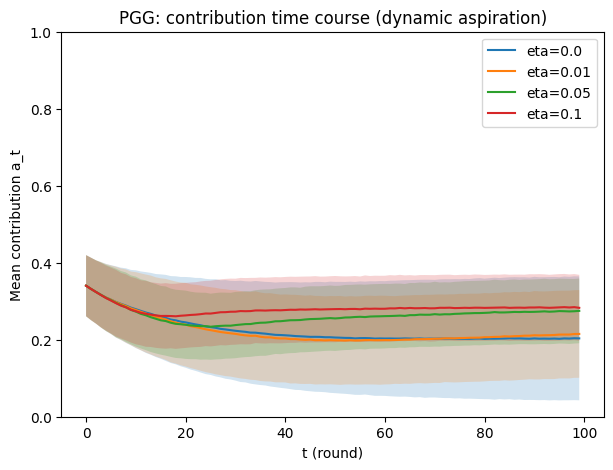

In [29]:
plt.figure(figsize=(7,5))

for eta in eta_list:
    actions = results[eta][0]      # (episodes, t, agents) contributions in [0,1]
    mean, std = coop_timecourse_mean_sd(actions)

    plt.plot(mean, label=f"eta={eta}")
    plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)

plt.xlabel("t (round)")
plt.ylim(0, 1)
plt.ylabel("Mean contribution a_t")
plt.title("PGG: contribution time course (dynamic aspiration)")
plt.legend()
plt.show()

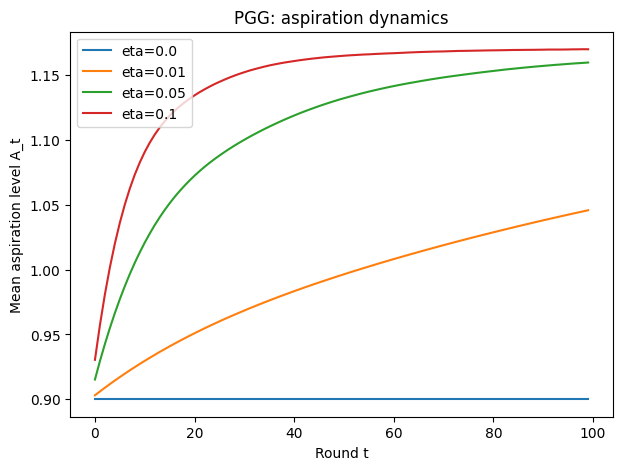

In [30]:
plt.figure(figsize=(7,5))

for eta in eta_list:
    A = results[eta][3]
    A_mean = A.mean(axis=(0,2))
    plt.plot(A_mean, label=f"eta={eta}")

plt.xlabel("Round t")
plt.ylabel("Mean aspiration level A_t")
plt.title("PGG: aspiration dynamics")
plt.legend()
plt.show()

In [ ]:
eta_list = [0.0, 0.01, 0.05, 0.1]
X_tresh = X
t_start, t_end = 1, ep_length

fig, axes = plt.subplots(len(eta_list), 1, figsize=(10, 10), sharex=True, sharey=True)
if len(eta_list) == 1:
    axes = [axes]

for ax, eta in zip(axes, eta_list):
    actions = results[eta][0]

    curves = cc_mcc(actions, t_start=t_start, t_end=t_end, tresh=X_tresh)
    f = curves["f_vals"]

    ax.plot(f, curves["pC"],   marker="o", label="not conditioned")
    ax.plot(f, curves["pC_C"], marker="^", label="prev=C (a>=X)")
    ax.plot(f, curves["pC_D"], marker="s", label="prev=D (a<X)")

    ax.set_title(f"PGG CC/MCC: eta={eta} (X={X_tresh})")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Contribution $a_t$")

axes[-1].set_xlabel("Avg contribution of others (prev round) $f_c$")

axes[0].legend(loc="lower right")
plt.tight_layout()
plt.show()



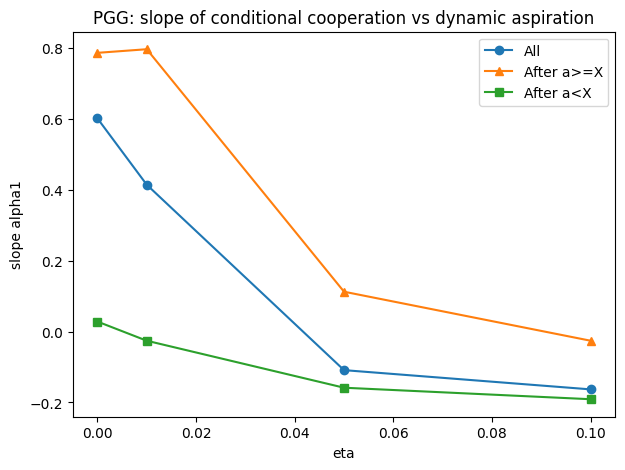

In [ ]:
alphas_all = []
alphas_C = []
alphas_D = []

for eta in eta_list:
    actions = results[eta][0]
    a1_all, a2_all, n_all = alpha_fit_polyfit(actions, condition=None, t_start=1, t_end=ep_length, tresh=X)
    a1_C,   a2_C,   n_C   = alpha_fit_polyfit(actions, condition="prevC", t_start=1, t_end=ep_length, tresh=X)
    a1_D,   a2_D,   n_D   = alpha_fit_polyfit(actions, condition="prevD", t_start=1, t_end=ep_length, tresh=X)

    alphas_all.append(a1_all)
    alphas_C.append(a1_C)
    alphas_D.append(a1_D)

plt.figure(figsize=(7,5))
plt.plot(eta_list, alphas_all, "o-", label="All")
plt.plot(eta_list, alphas_C, "^-", label="After a>=X")
plt.plot(eta_list, alphas_D, "s-", label="After a<X")
plt.xlabel("eta")
plt.ylabel("slope alpha1")
plt.title("PGG: slope of conditional cooperation vs dynamic aspiration")
plt.legend()
plt.show()


In [ ]:
actions = results[0.0][0]
actions.min(), actions.max()

(np.float64(3.575365781216533e-07), np.float64(0.9999883770942688))

In [ ]:
A0 = results[0.0][3].mean()
A1 = results[0.1][3].mean()
A0, A1

(np.float64(0.9000000000000001), np.float64(1.1436864023585949))

In [ ]:
actions = results[0.0][0]  # EXACTEMENT les données eta=0.0

out = cc_mcc(actions, t_start=1, t_end=25, tresh=0.4)

print(out["f_vals"][:5])
print(out["pC"][:5], out["pC_C"][:5], out["pC_D"][:5])

[0.07692308 0.15384615 0.23076923 0.30769231 0.38461538]
[0.31418988 0.29412677 0.27095399 0.25611168 0.25053544] [0.43649292 0.45227503 0.4616074  0.46718053 0.47747799] [0.24995474 0.22601403 0.20729394 0.20026177 0.19472465]


In [ ]:
actions = results[0.0][0]  # (episodes, t, 4)

# prends un épisode pour illustrer
tr = 0
t = 10
a_prev = actions[tr, t-1, :]  # contributions à t-1

X = 0.4
avg_continuous = (a_prev.sum() - a_prev) / 3.0
frac_binary = ((a_prev >= X).sum() - (a_prev >= X)) / 3.0

print("avg continuous:", avg_continuous)
print("frac binary:", frac_binary)

avg continuous: [0.11010057 0.26099428 0.25014396 0.19701313]
frac binary: [0.         0.33333333 0.33333333 0.33333333]


In [ ]:
print("seed =", SEED)
print("n_episodes =", n_episodes)
print("A0,beta,X,sigma,p_init_mode =", A0, beta, X, sigma, p_init_mode)

seed = 123
n_episodes = 1000
A0,beta,X,sigma,p_init_mode = 0.9000000000000001 0.5 0.4 0.2 random


In [ ]:
import analysis_PGG, importlib
print("analysis_PGG file =", analysis_PGG.__file__)

analysis_PGG file = c:\ULB\INFO-F409 - Learning dynamics\Project\LearningDynamics_Paper\results\../src\analysis_PGG.py
